In [ ]:
import pandas as pd
from pathlib import Path

logging_directory = Path("/workspaces/experimental-wsd/lightning_logs").resolve()
model_version = 193
model_log_path = Path(logging_directory, f"version_{model_version}", "metrics.csv")
model_metrics = pd.read_csv(model_log_path)

In [ ]:
from typing import Literal
import matplotlib.pyplot as plt

def loss_data_by_step(data: pd.DataFrame,
                      split_name: Literal["train", "validation"]) -> pd.DataFrame:
    """
    Given the logging data from a machine learning run it will generate the 
    loss values of the given split whereby the loss value comes from the 
    epoch loss, if the loss value is calculated multiple times per epoch, e.g. 
    a validation loss epoch is calculated multiple times during a training 
    cycle then these values will be displayed.
    
    All values are displayed with a frequency of steps rather then epochs.

    The returned dataframe will contain the following:
    

    Args:
        data (pd.DataFrame): The log data from the machine learning run.
        split_name (Literal[`train`, `validation`]): The name of the split 
            that the loss values should come from.
    Returns:
        pd.DataFrame: The dataframe containing the averaged loss at each 
            `step`.
    """
    
    loss_column_name = f"{split_name}_loss_epoch"
    subset_data = data[data[loss_column_name].notna()]
    
    return pd.DataFrame({"step": subset_data["step"],
                         f"{split_name}_loss": subset_data[loss_column_name]})

def loss_data_by_epoch(data: pd.DataFrame,
                       split_name: Literal["train", "validation"]
                       ) -> pd.DataFrame:
    """
    Given the logging data from a machine learning run it will generate the 
    loss values of the given split whereby the loss value comes from the 
    epoch loss, if the loss value is calculated multiple times per epoch, e.g. 
    a validation loss epoch is calculated multiple times during a training 
    cycle then these values will be averaged, using the mean, as this function 
    will require one epoch value per loss value.
    
    All values are displayed with a frequency of epochs rather then steps.

    The returned dataframe will contain the following:
    

    Args:
        data (pd.DataFrame): The log data from the machine learning run.
        split_name (Literal[`train`, `validation`]): The name of the split 
            that the loss values should come from.
    Returns:
        pd.DataFrame: The dataframe containing the averaged loss at each 
            `epoch`.
    """
    
    loss_column_name = f"{split_name}_loss_epoch"
    subset_data = data[data[loss_column_name].notna()]
    grouped_subset_data = subset_data.groupby("epoch")[[loss_column_name, "epoch"]].mean()
    
    return pd.DataFrame({"epoch": grouped_subset_data["epoch"],
                         f"{split_name}_loss": grouped_subset_data[loss_column_name]})

def metric_data(data: pd.DataFrame,
                metric: str,
                plotting_frequency: Literal["step", "epoch"]) -> pd.DataFrame:
    """
    Given the logging data from the machine learning run it will return a 
    Pandas DataFrame with the following key/values:

    `metric`: An numpy array of the associated metric data with all NaN values 
        removed.
    `plotting_frequency`: The plotting frequency, e.g. step number, epoch number 
        for the associated metric value.

    if `plotting_frequency` is `step` then it will return all of the metric values 
    for each step as there is a one to one relationship between step and metric. 
    If it is `epoch` it will return the last reported metric for that epoch as in 
    some cases there are many metric values for one epoch value as sometimes 
    we evaluate more than once per epoch.

    Args:
        data (pd.DataFrame): The log data for the machine learning run.
        metric (str): The name of the metric, e.g. `validation_accuracy` you 
            want returned.
        plotting_frequency (Literal[`step`, `epoch`]): The frequency of the 
            metric data to return.
    Returns:
        pd.DataFrame: A dataframe containing both the metric and it's frequency.
    """
    subset_data = data[data[metric].notna()]
    if plotting_frequency == "epoch":
        subset_data = subset_data.groupby(plotting_frequency).apply(lambda x: x.iloc[-1],
                                                                    include_groups=False)
        subset_data = subset_data.reset_index()

    return pd.DataFrame({
        plotting_frequency: subset_data[plotting_frequency],
        metric: subset_data[metric]
    })


def optimizer_data(data: pd.DataFrame,
                   optimizer_name: str) -> pd.DataFrame:
    """
    Given the logging data from the machine learning run it will return a 
    pandas DataFrame with the following key/values:

    `optimizer_name`: The value of the learning rate for the given step.
    `step`: The step number.

    Args:
        data (pd.DataFrame): The log data for the machine learning run.
        optimizer_name (str): The name of the optimizer, e.g. lr-AdamW
    Returns:
        pd.DataFrame: A dataframe containing both the optimizer learning rate 
            value and the step value.
    """
    optimizer_data = data[(data[optimizer_name].notna()) & (data["step"].notna())]
    return pd.DataFrame(
        {
            optimizer_name: optimizer_data[optimizer_name],
            "step": optimizer_data["step"]
        }
    )


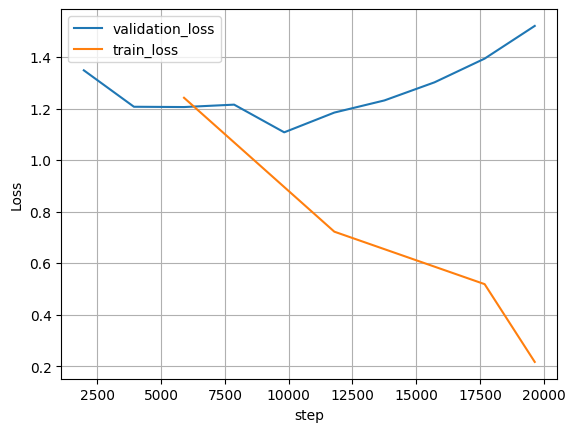

In [ ]:
fig, ax = plt.subplots()
validation_loss = pd.DataFrame(loss_data_by_step(model_metrics, "validation"))
train_loss = pd.DataFrame(loss_data_by_step(model_metrics, "train"))

validation_loss.plot("step", "validation_loss", grid=True, legend=True, xlabel="Steps", ylabel="Loss", ax=ax)
train_loss.plot("step", "train_loss", grid=True, legend=True, ax=ax)
plt.show()

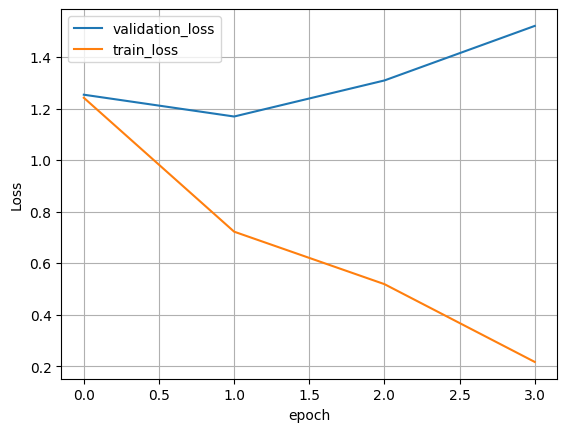

In [65]:
fig, ax = plt.subplots()
validation_loss = pd.DataFrame(loss_data_by_epoch(model_metrics, "validation"))
train_loss = pd.DataFrame(loss_data_by_epoch(model_metrics, "train"))

validation_loss.plot("epoch", "validation_loss", grid=True, legend=True, xlabel="Epoch", ylabel="Loss", ax=ax)
train_loss.plot("epoch", "train_loss", grid=True, legend=True, ax=ax)
plt.show()

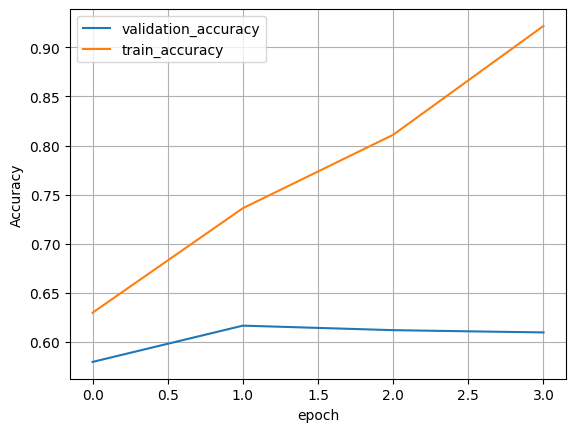

In [68]:
fig, ax = plt.subplots()
validation_loss = metric_data(model_metrics, "validation_accuracy", "epoch")
train_loss = metric_data(model_metrics, "train_accuracy", "epoch")
validation_loss.plot("epoch", "validation_accuracy", grid=True, legend=True, xlabel="Steps", ylabel="Accuracy", ax=ax)
train_loss.plot("epoch", "train_accuracy", grid=True, legend=True, ax=ax)
plt.show()

<Axes: xlabel='step'>

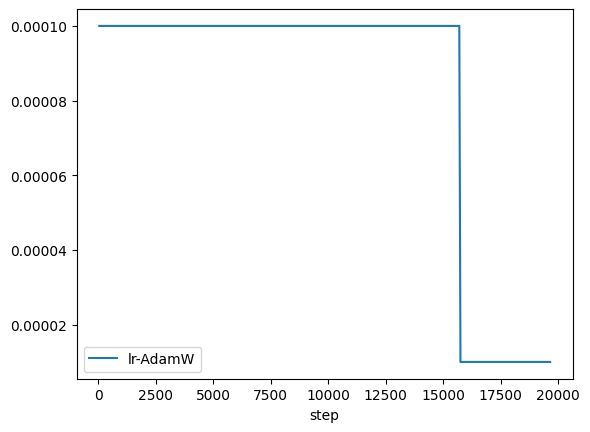

In [16]:
optimizer_data(model_metrics, "lr-AdamW").plot("step", "lr-AdamW")